# 0. Install Dependencies

In [1]:
!pip install psycopg2-binary
!pip install wordcloud
!pip install gensim
!pip install pyLDAvis
!pip install nltk
!pip install Sastrawi
!pip install datasets
!pip install rich


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from datasets import load_dataset

# Wordcloud
from wordcloud import WordCloud

# NLP
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

import requests
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Topic Modeling
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
import pyLDAvis.gensim

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\binta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\binta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 1. Get Data

In [ ]:
# koneksi ke PostgreSQL
conn = psycopg2.connect(
    host="localhost",
    database="artikel_berita",
    user="postgres",
    password ="XXXXXX",
    port=5432
)

df = pd.read_sql_query("SELECT id, date, location, title, content FROM data_artikel WHERE date BETWEEN '2025-03-25' AND '2025-09-25' ORDER BY date DESC;", conn)
conn.close()

df['date'] = pd.to_datetime(df['date'])
df.head()

C:\Users\binta\AppData\Local\Temp\ipykernel_18948\287775678.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT id, date, location, title, content FROM data_artikel WHERE date BETWEEN '2025-03-25' AND '2025-09-25' ORDER BY date DESC;", conn)


,id,date,location,title,content
0,e3caf49ac7af6c427c81fe96257319ec,2025-09-25,manggarai barat,pelaku pencabulan siswi sd di manggarai timur ...,disclaimer informasi berikut ini tidak ditujuk...
1,d99ffbd9025bde0b2c4a81fee0674733,2025-09-25,medan,cerita pemilik kos wartawan tewas di medan den...,polisi menggelar pra rekonstruksi kematian war...
2,10f72ae84e5e2616bbe941d992b2058a,2025-09-25,jakarta,tawuran maut di cikarang nyawa melayang,aksi tawuran dua kelompok remaja di cikarang u...
3,00cafe8e673e64bcd6ab8c8a2c826278,2025-09-25,lombok barat,rekonstruksi pembunuhan mahasiswi di pantai ni...,rekonstruksi pembunuhan mahasisiwi universitas...
4,1ef821013ecba9115b7b7d547c76361d,2025-09-25,sinjai,dosen uiad sinjai dikeroyok rekan kerja dalam ...,dosen universitas islam ahmad dahlan uiad sinj...


In [154]:
df.shape

(4105, 5)

# 2. Text Preprocessing (NLP)

## 2.1. Normalization

In [ ]:
# Custom normalization dictionary
normalisasi_dict = {
    "aku": "saya",
    "gua": "saya",
    "kamu": "anda",
    "kak": "kakak",
    "bu": "ibu",
    "mas": "kakak",
    "mbak": "kakak",
    "mba": "kakak",
    "nek": "nenek",
    "kek": "kakek",
    "bpk": "bapak",
    "pak": "bapak",
    "nggak": "tidak",
    "gak": "tidak",
    "ga": "tidak",
    "trs": "terus",
    "dlm": "dalam",
    "korban2": "korban",
    "pelaku2": "pelaku",
    "penjara2": "penjara",
    "jogja": "yogyakarta",
    "as": "amerika serikat",
    "us": "amerika serikat",
    "rp": "rupiah",
    "jt": "juta",
    "milyar": "miliar",
    "milliar": "miliar",
    "mil": "miliar",
    "rb": "ribu",
    "org": "orang",
    "tgl": "tanggal",
    "dgn": "dengan",
    "yg": "yang",
    "pd": "pada",
    "thn": "tahun",
    "bln": "bulan",
    "hr": "hari",
    "jm": "jam",
    "mn": "menit",
    "dtk": "detik",
    "kg": "kilogram",
    "km": "kilometer",
    "m": "meter",
    "cm": "sentimeter",
    "mm": "milimeter",
    "tbk": "terbuka",
    "ttd": "tertanda",
    "no": "nomor",
    "alm": "almarhum",
    "jh": "jenazah",
    "sdr": "saudara",
    "bpk": "bapak",
    "online": "daring",
    "offline": "luring",
    "app": "aplikasi",
    "info": "informasi",
    "travel": "perjalanan",
    "jobs": "pekerjaan",
    "mobi": "seluler",
    "tel": "telekomunikasi",
    "post": "pos",
    "xxx": "pornografi",
    "loan": "pinjaman",
    "win": "menang",
    "bid": "tawaran",
    "click": "klik",
    "link": "tautan",
    "shop": "toko",
    "store": "toko",
    "market": "pasar",
    "news": "berita",
    "rich": "kaya",
    "poor": "miskin",
    "happy": "bahagia",
    "sad": "sedih",
    "angry": "marah",
    "calm": "tenang",
    "stress": "tekanan",
    "launch": "luncurkan",
    "publish": "terbitkan",
    "like": "suka",
    "strategy": "strategi",
    "finance": "keuangan",
    "trend": "tren",
    "fashion": "mode",
    "style": "gaya",
    "movie": "film",
    "tv": "televisi",
    "body": "tubuh",
    "health": "kesehatan",
    "province": "provinsi",
    "city": "kota",
    "community": "komunitas",
    "society": "masyarakat",
    "culture": "budaya",
    "government": "pemerintah",
    "politics": "politik",
    "policy": "kebijakan",
    "law": "hukum",
    "partner": "mitra",
    "resident": "penduduk",
    "people": "orang", 
    "individual": "individu",
    "human": "manusia",
    "man": "pria",
    "woman": "wanita",
    "child": "anak",
    "baby": "bayi",
    "kid": "anak",
    "professor": "profesor",
    "musician": "musisi",
    "actor": "aktor",
    "actress": "aktris",
    "director": "sutradara",
    "producer": "produser",
    "writer": "penulis",
    "author": "penulis",
    "journalist": "wartawan",
    "reporter": "reporter",
    "editor": "editor",
    "publisher": "penerbit",
    "developer": "pengembang",
    "analyst": "analis",
    "manager": "manajer",
    "executive": "eksekutif",
    "team": "tim",
    "group": "kelompok",
    "organization": "organisasi",
    "company": "perusahaan",
    "business": "bisnis",
    "industry": "industri",
    "sector": "sektor",
    "market": "pasar",
    "economy": "ekonomi",
    "trade": "perdagangan",
    "commerce": "perdagangan",
    "finance": "keuangan",
    "investment": "investasi",
    "rate": "tingkat",
    "research": "penelitian",
    "analysis": "analisis",
    "intelligence": "kecerdasan",
    "smart": "pintar",
    "genius": "jenius",
    "skill": "keterampilan",
    "award": "penghargaan",
    "honor": "kehormatan",
    "respect": "hormat",
    "donation": "sumbangan",
    "volunteer": "relawan",
    "service": "layanan",
    "help": "bantuan",
    "support": "dukungan",
    "rescue": "penyelamatan",
    "save": "selamatkan",
    "protect": "lindungi",
    "defend": "pertahankan",
    "guard": "jaga",
    "secure": "amankan",
    "safety": "keselamatan",
    "security": "keamanan",
    "danger": "bahaya",
    "risk": "risiko",
    "threat": "ancaman",
    "harm": "bahaya",
    "injury": "cedera",
    "torture": "penyiksaan",
    "abuse": "pelecehan",
    "violence": "kekerasan",
    "force": "kekuatan",
    "power": "kekuasaan",
    "impact": "dampak",
    "effect": "efek",
    "result": "hasil",
    'tak': 'tidak',
    'tida': 'tidak',
    'nggak': 'tidak',
    'gak': 'tidak',
    'ga': 'tidak',
    'masyarakat': 'warga'
}

In [ ]:
combined_dict = normalisasi_dict

def normalize_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    tokens = text.split()
    normalized_tokens = [combined_dict.get(token, token) for token in tokens]
    return " ".join(normalized_tokens)

df['normalized'] = df['content'].apply(normalize_text)
df[['normalized']].head()

,normalized
0,disclaimer informasi berikut ini tidak ditujuk...
1,polisi menggelar pra rekonstruksi kematian war...
2,aksi tawuran dua kelompok remaja di cikarang u...
3,rekonstruksi pembunuhan mahasisiwi universitas...
4,dosen universitas islam ahmad dahlan uiad sinj...


## 2.2. Stopword Removal

In [ ]:
# stopword
factory = StopWordRemoverFactory()
sastrawi_stopwords = set(factory.get_stop_words())

custom_stopwords = {
    #  Kata penghubung / kata netral umum
    "ujar", "kata", "dikatakan", "menjelaskan", "mengungkapkan", "dijelaskan", "ditambahkan",
    "menyampaikan", "disebut", "diumumkan", "diperoleh", "menegaskan", "mengatakan", "mengumumkan",
    "menyebut", "dijabarkan", "dipaparkan", "menyatakan", "saat", "kepada", "bahwa", "akan", "sudah",
    "dengan", "ini", "itu", "adalah", "telah", "masih", "baru", "juga", "lagi", "maka", "karena", "jika",
    "bila", "sebagai", "menjadi", "dapat", "per", "terhadap", "sehingga", "sekitar", "hanya", "saja",
    "memang", "selalu", "cukup", "lebih", "kurang", "tersebut", "lain", "lainnya", "begitu", "begitulah",
    "namanya", "oleh", "dari", "hingga", "sedangkan", "meski", "meskipun", "bahkan", "apalagi", "pula",
    "tetapi", "sementara", "sebab", "demi", "tidak","ujar", "ada", "ata", "terus", "detik", "tunjuk", "putu", 
    "dasar", "terkait", "tak", "harap", "kemudian", "lalu", "selanjutnya", "seperti", "senin", "selasa", "rabu", 
    "kamis", "jumat", "sabtu", "minggu", "apa", "apabila", "jika", "kalau", "proses", "umum", "reserse", "jika",
    "kalau", "giat", "soal", "tetap", "kalo", "jika", "ingin", "mau", "wisata", "dapat", "tambah", "benar", "belum", 
    "ucap", "pungkas", "ada", "kini", "usaha", "ade", "ciri", "buat", "kabupaten", "kota", "langsung", 'polres', "polda", 
    "jaya", "sim", "gambas", "kerah", "minta", "kondisi", "tahu", "karaoke", "maka", "bila", "karena", "sudah",
    "ternyata", "akibat", "aku", "saya", "anda", "kamu", "giat", "proses", "rk", "ridwan", "lisa", "rizky", "bambang", "faizal", 
    "egianus", "tengah", "barat", "timur", "selatan", "utara", "rupa", "pusat", "identifikasi", "gambas", "labu", "pandu", 
    "menit", "detik", "jam", "kemarin", "besok", "libur", "jaga", "berbagai", "terjadi", "menarik", "hal", "yang", "kan", "di",
    "ke", "dan", "atau", "memang", "justru", "seperti", "iya", "ya, 'tunjuk", "lalu", "mulai", "selesai", "akhir", "buat", "guna", "pasti", 
    "sampai", "laksana", "lalu", "kemudian", "tunjuk", "melaporkan", "laporan", "usai", "memulai", "selesai", "akhirnya", "warga","menyempatkan", "memberitahu",
    "kasus", "memasuki", "peristiwa", "pernah", "belum", "sendiri", "terkena", "memakai", "memerintah", "sangat", "tega", "memeriksa",
    "menduga", "menutupi", "sejak", "waktu", "maupun", "sedang", "hadir", "putu", "melanjutkan", "aku", "benar", "nama", "arah", "depan", 
    "belakang", "atas", "bawah", "perlu", "milik", "sampai", "rasa", "tangkut", "melaksanakan", "lakssana", "mendapati", "mendapatkan",
    "satu", "dua", "tiga", "empat", "lima", "enam", "tujuh", "delapan", "sembilan", "sepuluh", "hari", "nussa", "terkena", "tempat", "lokasi", 
    "hana", "tugas", "masalah", "lidi", "giat","artanto", "baik", "membaik", "memburuk", "jahat", "dukung", "mendukung", "mengutamakan", "utama", "tindak",
    "tahun", "buat", "membuat", "berhari", "harian", "hari", "temu", "menemukan", "camat", "mengaku", "aku", "tersangka", "sidi", "menetapkan", 
    "tetap", "memeriksa", "mataram", "perkara", "ntb", "striptis", "kombes", "tari", "wisata", "menari"
    
    # Kata media / sumber berita
    "dll", "dkk", "detikcom", "detik.com", "detikjateng", "detiksumut", "detikjabar", "detiksulsel",
    "detiknews", "detikbali", "detikjatim", "kompas", "tribunnews", "liputan6", "cnn", "antara", "berita",
    "tribun", "tv", "online", "news", "dotcom", "co", "id",
    
    # Kata netral lain
    "lainnya", "beberapa", "semua", "setiap", "sebagian", "tanpa", "namun", "selanjutnya", "kemudian",
    "untuk", "di", "pada", "tentang", "pihak", "hasil", "lokal", "ops", "cartenz", "nekat", "besar", "kecil", 
    "buat", "cerita", "wib", "wit", "wita", "makin", "semakin", "tetap", "sesuai", "beri", 
    
}

stopwords_final = sastrawi_stopwords.union(custom_stopwords)
def remove_stopwords(text):
    tokens = text.split()
    filtered = [t for t in tokens if t not in stopwords_final]
    return " ".join(filtered)

df['stopword'] = df['normalized'].apply(remove_stopwords)
df[['normalized', 'stopword']].head()

,normalized,stopword
0,disclaimer informasi berikut ini tidak ditujuk...,disclaimer informasi berikut ditujukan mengins...
1,polisi menggelar pra rekonstruksi kematian war...,polisi menggelar pra rekonstruksi kematian war...
2,aksi tawuran dua kelompok remaja di cikarang u...,aksi tawuran kelompok remaja cikarang bekasi j...
3,rekonstruksi pembunuhan mahasisiwi universitas...,rekonstruksi pembunuhan mahasisiwi universitas...
4,dosen universitas islam ahmad dahlan uiad sinj...,dosen universitas islam ahmad dahlan uiad sinj...


## 2.3. Tokenization

In [159]:
df['tokenized'] = df['stopword'].apply(word_tokenize)
df[['normalized', 'stopword', 'tokenized']].head()

,normalized,stopword,tokenized
0,disclaimer informasi berikut ini tidak ditujuk...,disclaimer informasi berikut ditujukan mengins...,"[disclaimer, informasi, berikut, ditujukan, me..."
1,polisi menggelar pra rekonstruksi kematian war...,polisi menggelar pra rekonstruksi kematian war...,"[polisi, menggelar, pra, rekonstruksi, kematia..."
2,aksi tawuran dua kelompok remaja di cikarang u...,aksi tawuran kelompok remaja cikarang bekasi j...,"[aksi, tawuran, kelompok, remaja, cikarang, be..."
3,rekonstruksi pembunuhan mahasisiwi universitas...,rekonstruksi pembunuhan mahasisiwi universitas...,"[rekonstruksi, pembunuhan, mahasisiwi, univers..."
4,dosen universitas islam ahmad dahlan uiad sinj...,dosen universitas islam ahmad dahlan uiad sinj...,"[dosen, universitas, islam, ahmad, dahlan, uia..."


## 2.4. Stemming

In [160]:
# stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from rich.progress import track

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(tokens):
    text = ' '.join(tokens)
    return stemmer.stem(text).split()

stemmed_results = []
for tokens in track(df['tokenized'], description="Stemming..."):
    stemmed_results.append(stem_text(tokens))

df['stemmed'] = stemmed_results
df[['normalized', 'stopword', 'tokenized', 'stemmed']].head()

Output()

,normalized,stopword,tokenized,stemmed
0,disclaimer informasi berikut ini tidak ditujuk...,disclaimer informasi berikut ditujukan mengins...,"[disclaimer, informasi, berikut, ditujukan, me...","[disclaimer, informasi, ikut, tuju, inspirasi,..."
1,polisi menggelar pra rekonstruksi kematian war...,polisi menggelar pra rekonstruksi kematian war...,"[polisi, menggelar, pra, rekonstruksi, kematia...","[polisi, gelar, pra, rekonstruksi, mati, warta..."
2,aksi tawuran dua kelompok remaja di cikarang u...,aksi tawuran kelompok remaja cikarang bekasi j...,"[aksi, tawuran, kelompok, remaja, cikarang, be...","[aksi, tawur, kelompok, remaja, cikarang, beka..."
3,rekonstruksi pembunuhan mahasisiwi universitas...,rekonstruksi pembunuhan mahasisiwi universitas...,"[rekonstruksi, pembunuhan, mahasisiwi, univers...","[rekonstruksi, bunuh, mahasisiwi, universitas,..."
4,dosen universitas islam ahmad dahlan uiad sinj...,dosen universitas islam ahmad dahlan uiad sinj...,"[dosen, universitas, islam, ahmad, dahlan, uia...","[dosen, universitas, islam, ahmad, dahlan, uia..."


In [161]:
df.to_csv("hasil_stemming.csv", index=False, encoding="utf-8")

# 3. Topic Modeling

In [ ]:
# df = pd.read_csv('hasil_stemming.csv')
df_topic = df[['id', 'content', 'stemmed']]
df_topic.head()

,id,content,stemmed
0,e3caf49ac7af6c427c81fe96257319ec,disclaimer informasi berikut ini tidak ditujuk...,"[disclaimer, informasi, ikut, tuju, inspirasi,..."
1,d99ffbd9025bde0b2c4a81fee0674733,polisi menggelar pra rekonstruksi kematian war...,"[polisi, gelar, pra, rekonstruksi, mati, warta..."
2,10f72ae84e5e2616bbe941d992b2058a,aksi tawuran dua kelompok remaja di cikarang u...,"[aksi, tawur, kelompok, remaja, cikarang, beka..."
3,00cafe8e673e64bcd6ab8c8a2c826278,rekonstruksi pembunuhan mahasisiwi universitas...,"[rekonstruksi, bunuh, mahasisiwi, universitas,..."
4,1ef821013ecba9115b7b7d547c76361d,dosen universitas islam ahmad dahlan uiad sinj...,"[dosen, universitas, islam, ahmad, dahlan, uia..."


In [ ]:
# daftar stopword manual
stopword_m = ["ada", "tetap", "subdit", "sama", "manang", "ungkap", "uja", "randi", "sedia", 
            "ikut", "rupa", "labu", "besar", "kecil", "nomor", "ditreskrimum", "tahu", "guna", "taufik", 
            "resmob", "diksar", "bajo", "kondisi", "kilogram", "kartu", "tingkat", "camat", "beri", 
            "terbang", "mansion", "jateng", "tahan", "jakarta", "bandung", "satu", "dua", "tiga", "iy", "giat", 
            "inisial", "bal", "bagi", "pantai", "banyak", "sedikit", "jawa", "unpad", "al", "rshs", "priguna", "ppds", 
            "surawan", "hasil", "buah", "sukabumi", "garut", "purwakarta", "desa", "kota", "tinggal", "nyata", 
            "mungkin", "simak", "residen", "fk", "rachim", "fakultas", "jabar", "maret", "april", "mei", "juni", "juli", "agustus", "september",
            "dulang", "yusuf", "pasti", "cari", "selamat", "siliwangi", "abdul", "ti", "muara", "pramono", "dr", "karawang", "sila", 
            "ruko", "f", "ronald", "ary", "metro", "bukan", "harap", "lanjut", "seluruh", "sidi", "sangkut", "gelar", 
            "ruang", "ayat", "budi", "tim", "milik", "calon", "pt", "pasang", "sumut", "makan", "jatanras", "candra", "wira", "wetan", "boy", 
            "nali", "dedi", "ts", "alex", "md", "kabel", "mbah", "herry", "karung", "heryawan", "padalarang", "geser", "anung", "tupon", "lidi", "yahukimo"
            "pekanbaru", "muara", "dad", "operasional", "patar", "enm", "dokter", "bawa", "didik", "sempat", "lihat", "pasien", "guru", "temu"]

# hapus stopword per kata
df_topic["stemmed_m"] = df_topic["stemmed"].apply(
    lambda tokens: [word for word in tokens if word not in stopword_m])

C:\Users\binta\AppData\Local\Temp\ipykernel_18948\3823275497.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topic["stemmed_m"] = df_topic["stemmed"].apply(


In [ ]:
texts = df_topic['stemmed_m']

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=3, no_above=0.6)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
from gensim.models import LdaModel, CoherenceModel
from rich.progress import track

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []

    for num_topics in track(range(start, limit, step), description="Evaluasi Model LDA..."):
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            update_every=1,
            chunksize=20,
            passes=1,
            alpha='auto',
            per_word_topics=True
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=2, limit=20, step=1)

# coherence scores untuk pilih jumlah topik terbaik
for i, cv in enumerate(coherence_values):
    print(f'Num Topics = {i+2}, Coherence Score = {cv:.4f}')

Output()

Num Topics = 2, Coherence Score = 0.4526
Num Topics = 3, Coherence Score = 0.4486
Num Topics = 4, Coherence Score = 0.4391
Num Topics = 5, Coherence Score = 0.4793
Num Topics = 6, Coherence Score = 0.5365
Num Topics = 7, Coherence Score = 0.4867
Num Topics = 8, Coherence Score = 0.4285
Num Topics = 9, Coherence Score = 0.4624
Num Topics = 10, Coherence Score = 0.4692
Num Topics = 11, Coherence Score = 0.4357
Num Topics = 12, Coherence Score = 0.4773
Num Topics = 13, Coherence Score = 0.4364
Num Topics = 14, Coherence Score = 0.4238
Num Topics = 15, Coherence Score = 0.4315
Num Topics = 16, Coherence Score = 0.4248
Num Topics = 17, Coherence Score = 0.4685
Num Topics = 18, Coherence Score = 0.4490
Num Topics = 19, Coherence Score = 0.4541


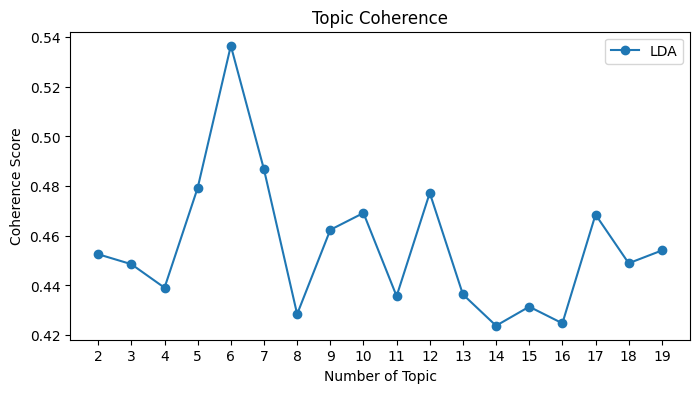

In [ ]:
x = range(2, 20, 1)
plt.figure(figsize=(8, 4))
plt.plot(x, coherence_values, marker="o", label="LDA")
plt.xlabel("Number of Topic")
plt.ylabel("Coherence Score")
plt.title("Topic Coherence")
plt.xticks(x)
plt.legend()
plt.show()

In [ ]:
best_model = model_list[coherence_values.index(max(coherence_values))]
topics = best_model.print_topics(num_words=20)
for topic in topics:
    print(topic)

(0, '0.014*"tni" + 0.013*"kkb" + 0.013*"senjata" + 0.013*"serang" + 0.012*"papua" + 0.011*"aman" + 0.010*"kriminal" + 0.009*"kelompok" + 0.009*"damai" + 0.009*"operasi" + 0.008*"yahukimo" + 0.008*"polri" + 0.007*"anggota" + 0.007*"evakuasi" + 0.007*"libat" + 0.007*"tindak" + 0.006*"jumlah" + 0.006*"tegas" + 0.006*"gunung" + 0.005*"tembak"')
(1, '0.036*"korban" + 0.021*"jadi" + 0.014*"jalan" + 0.014*"aman" + 0.014*"tangkap" + 0.013*"aksi" + 0.011*"motor" + 0.011*"pukul" + 0.010*"rumah" + 0.009*"duga" + 0.009*"pria" + 0.009*"video" + 0.009*"curi" + 0.007*"mobil" + 0.006*"alami" + 0.006*"datang" + 0.005*"salah" + 0.005*"tangan" + 0.005*"tugas" + 0.005*"lapor"')
(2, '0.012*"hukum" + 0.012*"negara" + 0.011*"sidang" + 0.010*"amerika" + 0.010*"serikat" + 0.008*"adil" + 0.008*"perintah" + 0.007*"putus" + 0.007*"program" + 0.006*"presiden" + 0.006*"video" + 0.005*"langgar" + 0.005*"indonesia" + 0.005*"surat" + 0.005*"hak" + 0.005*"oknum" + 0.005*"tulis" + 0.005*"pilih" + 0.005*"etik" + 0.005*"k

In [288]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
pyLDAvis.display(vis)

In [ ]:
# Mapping topik ke label
topic_mapping = {
    0: "Kejahatan Bersenjata",
    1: "Pencurian, Kekerasan Fisik",
    2: "Pelanggaran Hukum, Kasus Politik",
    3: "Kejahatan Seksual, Kekerasan Anak",
    4: "Kejahatan Ekonomi, Penipuan",
    5: "Pembunuhan, Penganiayaan"
}

def assign_topic_label(model, corpus, mapping):
    topic_labels = []
    for bow in corpus:
        topic_probs = model.get_document_topics(bow)
        top_topic = max(topic_probs, key=lambda x: x[1])[0]
        topic_labels.append(mapping[top_topic])
    return topic_labels

df["topic_label"] = assign_topic_label(best_model, corpus, topic_mapping)
df.sample(5)

,id,date,location,title,content,normalized,stopword,tokenized,stemmed,topic_label
1707,8b1ae4a5016f9ab48abd01a8115d16aa,2025-07-11,bandung,lisa mariana mangkir panggilan polisi soal kas...,lisa mariana kini harus menjalani kasus hukum ...,lisa mariana kini harus menjalani kasus hukum ...,mariana menjalani hukum jawa jabar mantan mode...,"[mariana, menjalani, hukum, jawa, jabar, manta...","[mariana, jalan, hukum, jawa, jabar, mantan, m...","Pelanggaran Hukum, Kasus Politik"
1646,1ce580f3302d5c56d4633557efa2af00,2025-07-14,majalengka,alasan si mulet bacok polisi saat gengnya biki...,polisi dan tni berhasil mengamankan anggota ge...,polisi dan tni berhasil mengamankan anggota ge...,polisi tni berhasil mengamankan anggota geng m...,"[polisi, tni, berhasil, mengamankan, anggota, ...","[polisi, tni, hasil, aman, anggota, geng, moto...","Pencurian, Kekerasan Fisik"
3026,4c6e44f26b43288e152fd538c0b9fd56,2025-05-16,jakarta,dipepet di pinggir jalan awas preman berkedok ...,hati hati premanisme berkedok debt collector a...,hati hati premanisme berkedok debt collector a...,hati hati premanisme berkedok debt collector m...,"[hati, hati, premanisme, berkedok, debt, colle...","[hati, hati, preman, kedok, debt, collector, m...","Pencurian, Kekerasan Fisik"
3734,55b932f27da0ddbb5c96077a7c6675de,2025-04-15,jakarta,kemlu ungkap wni dijebak jadi psk di dubai ora...,kementerian luar negeri kemlu mengungkap adany...,kementerian luar negeri kemlu mengungkap adany...,kementerian luar negeri kemlu mengungkap adany...,"[kementerian, luar, negeri, kemlu, mengungkap,...","[menteri, luar, negeri, kemlu, ungkap, ada, ba...",Kejahatan Bersenjata
920,94628755a8772c5530792f722de6f5d2,2025-08-15,jakarta,kapolri perintahkan jajaran cek stok beras di ...,kapolri jenderal listyo sigit prabowo memerint...,kapolri jenderal listyo sigit prabowo memerint...,kapolri jenderal listyo sigit prabowo memerint...,"[kapolri, jenderal, listyo, sigit, prabowo, me...","[kapolri, jenderal, listyo, sigit, prabowo, pe...",Kejahatan Bersenjata


# 5. Analisis

In [344]:
df_analisis = df[["date", "location", "topic_label"]]
df["date"] = pd.to_datetime(df["date"])
df_analisis.head()

,date,location,topic_label
0,2025-09-25,manggarai barat,"Kejahatan Seksual, Kekerasan Anak"
1,2025-09-25,medan,"Pembunuhan, Penganiayaan"
2,2025-09-25,jakarta,"Pencurian, Kekerasan Fisik"
3,2025-09-25,lombok barat,"Kejahatan Seksual, Kekerasan Anak"
4,2025-09-25,sinjai,"Pencurian, Kekerasan Fisik"


C:\Users\binta\AppData\Local\Temp\ipykernel_18948\1224652930.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


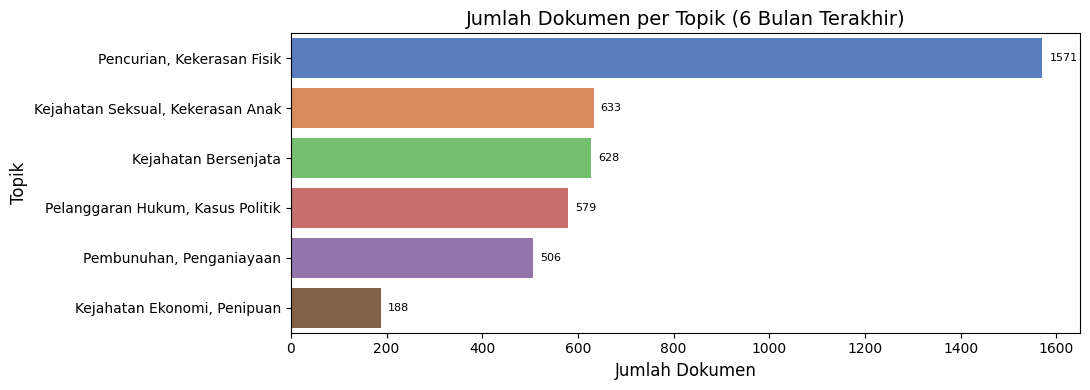

In [345]:
last_6_months = df["date"].max() - pd.DateOffset(months=6) 
df_last6 = df[df["date"] >= last_6_months] 

df_summary = df_last6.groupby("topic_label").size().reset_index(name="count") 
df_summary = df_summary.sort_values("count", ascending=False)

# plot
plt.figure(figsize=(11,4))
barplot = sns.barplot(
    data=df_summary,
    x="count",
    y="topic_label",
    palette="muted"   # palet kalem
)

# Tambahkan nilai di ujung bar
for p in barplot.patches:
    barplot.annotate(
        f'{int(p.get_width())}',  # nilai count
        (p.get_width(), p.get_y() + p.get_height() / 2),  
        ha='left', va='center',
        xytext=(5, 0), textcoords='offset points', fontsize=8
    )

plt.title("Jumlah Dokumen per Topik (6 Bulan Terakhir)", fontsize=14)
plt.xlabel("Jumlah Dokumen", fontsize=12)
plt.ylabel("Topik", fontsize=12)
plt.tight_layout()
plt.show()

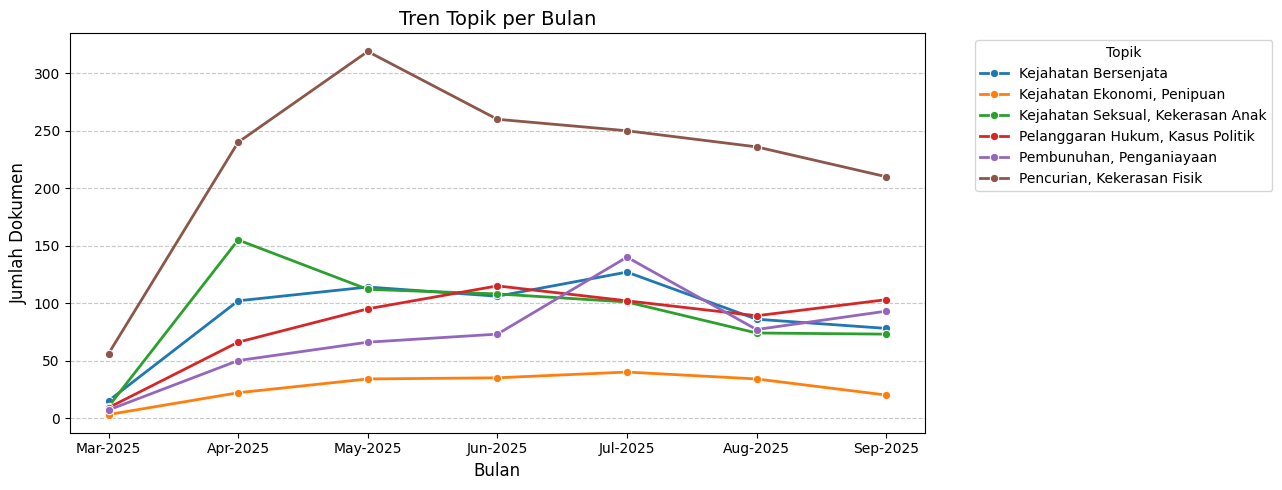

In [347]:
# hitung jumlah dokumen per bulan per topic
df_by_month = (df.groupby([df["date"].dt.to_period("M"), "topic_label"]).size().reset_index(name="count"))
df_by_month["date"] = df_by_month["date"].dt.to_timestamp()
df_by_month["month_year"] = df_by_month["date"].dt.strftime('%b-%Y')  # contoh: Apr-2025

# plot
plt.figure(figsize=(13,5))
sns.lineplot(
    data=df_by_month,
    x="month_year",
    y="count",
    hue="topic_label",
    marker="o",
    linewidth=2
)

plt.title("Tren Topik per Bulan", fontsize=14)
plt.ylabel("Jumlah Dokumen", fontsize=12)
plt.xlabel("Bulan", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Topik", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()